# 0. Install and Import dependencies

In [1]:
# Gym stuff
import gymnasium as gym
import gym_anytrading

# Stable baselines - rl stuff
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C

# Processing libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# gym trading and finta
from gym_anytrading.envs import StocksEnv
from finta import TA

# 1. Bring in Marketwatch GME Data 
https://www.marketwatch.com/investing/stock/gme/download-data?startDate=11/1/2019&endDate=03/12/2021

In [2]:
df = pd.read_csv('data/gmedata.csv')

In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', ascending=True, inplace=True)
df.set_index('Date', inplace=True)

In [4]:
df['Volume'] = df['Volume'].apply(lambda x: float(x.replace(",", "")))

## 2.1.3. Calculate SMA, RSI and OBV

In [5]:
df['SMA'] = TA.SMA(df, 12)
df['RSI'] = TA.RSI(df)
df['OBV'] = TA.OBV(df)
df.fillna(0, inplace=True)

## 2.1.4. Create New Environments

In [6]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Low', 'Volume','SMA', 'RSI', 'OBV']].to_numpy()[start:end]
    return prices, signal_features

In [7]:
class MyCustomEnv(StocksEnv):
    _process_data = add_signals
    
env2 = MyCustomEnv(df=df, window_size=12, frame_bound=(12,50))

In [8]:
df.head()

,Open,High,Low,Close,Volume,SMA,RSI,OBV
Date,,,,,,,,
2020-03-16,3.93,4.57,3.90,4.37,4866696.0,0.0,0.000000,0.0
2020-03-17,4.40,4.65,4.11,4.23,3562210.0,0.0,0.000000,-3562210.0
2020-03-18,4.10,4.25,3.50,3.77,3651709.0,0.0,0.000000,-7213919.0
2020-03-19,3.71,4.20,3.55,4.19,5039539.0,0.0,43.394834,-2174380.0
2020-03-20,4.08,4.08,3.65,3.76,7722194.0,0.0,29.351457,-9896574.0


# 3. Build Environment and Train

In [9]:
env_maker = lambda: env2
env = DummyVecEnv([env_maker])

In [10]:
model = A2C('MlpPolicy', env, verbose=1) 
model.learn(total_timesteps=100)

Using cpu device


# 4. Evaluation

In [11]:
env = MyCustomEnv(df=df, window_size=12, frame_bound=(63,100))
obs = env.reset()[0]

while True: 
    action, _states = model.predict(obs)
    obs, rewards, extra, done, info = env.step(action)
    if done:
        print("info", info)
        break

info {'total_reward': -0.17000000000000037, 'total_profit': 0.8686429011528355, 'position': <Positions.Long: 1>}


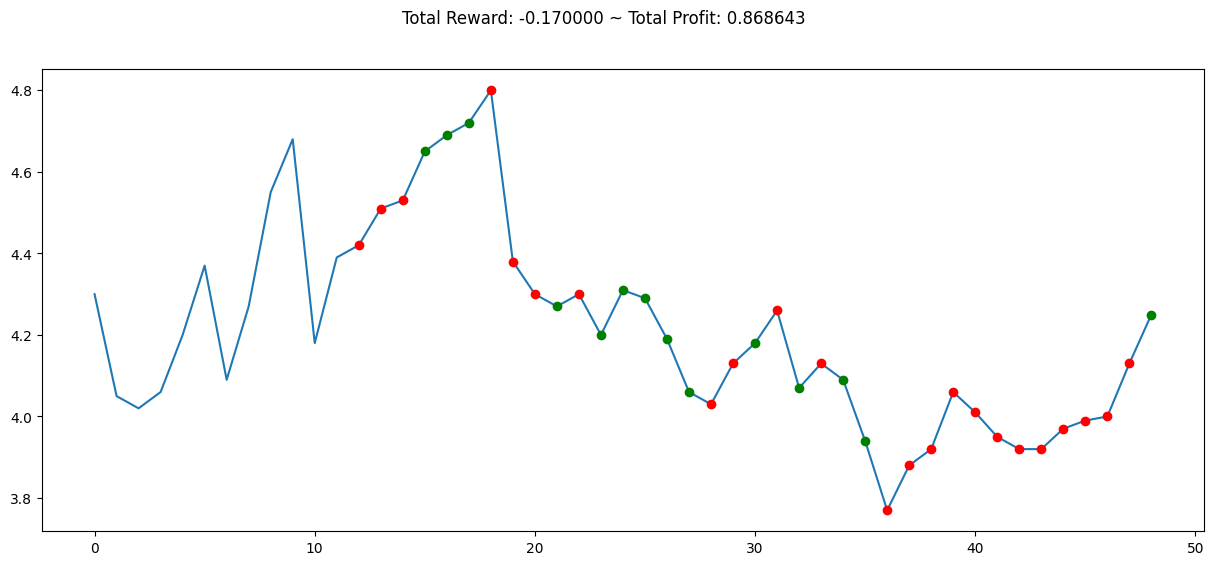

In [12]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()